# Gene Annotation

According to the paper, they have mapped to the human reference genome (hg19).
HG19 is the alias to GRCh37.

Human Gene Annotation - GENCODE Release 19 (GRCh37.p13). The gene annotation on the GRCh37 archive is based on Ensembl data from release 74.

https://www.gencodegenes.org/human/release_19.html

## Generate a dataframe with genes, transcripts and transcripts length

In [1]:
# Imports
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
# Read dataset
# File_in contains the comprehensive gene annotation on the reference chromosomes only
file_in = 'gencode.v19.annotation.gff3.gz'
df_data = pd.read_csv(file_in, sep='\t', header=None, comment='#')
print(" Shape: ", df_data.shape)    # 2.6M x 9
df_data.head(5)

 Shape:  (2615566, 9)


,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...


In [3]:
# Create column ID
df_data['ID'] = df_data.apply(
    lambda x: x[8][x[8].find('ID=')+3:x[8].find('.')], axis=1)

df_data.head(5)

,0,1,2,3,4,5,6,7,8,ID
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...,ENSG00000223972
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...,ENST00000456328
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...,exon:ENST00000456328
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...,exon:ENST00000456328
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...,exon:ENST00000456328


In [4]:
# Create column Parent

#The find() method returns the index of first occurrence of the substring (if found). If not found, it returns -1.
df_data['Parent'] = df_data.apply(
    lambda x: x[8].split(';')[1][7:x[8].split(';')[1].find('.')] if x[2] != 'gene' else 'nan', 
    axis=1)

df_data.head(10)

,0,1,2,3,4,5,6,7,8,ID,Parent
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...,ENSG00000223972,nan
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...,ENST00000456328,ENSG00000223972
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328
5,chr1,ENSEMBL,transcript,11872,14412,.,+,.,ID=ENST00000515242.2;Parent=ENSG00000223972.4;...,ENST00000515242,ENSG00000223972
6,chr1,ENSEMBL,exon,11872,12227,.,+,.,ID=exon:ENST00000515242.2:1;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242
7,chr1,ENSEMBL,exon,12613,12721,.,+,.,ID=exon:ENST00000515242.2:2;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242
8,chr1,ENSEMBL,exon,13225,14412,.,+,.,ID=exon:ENST00000515242.2:3;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242
9,chr1,ENSEMBL,transcript,11874,14409,.,+,.,ID=ENST00000518655.2;Parent=ENSG00000223972.4;...,ENST00000518655,ENSG00000223972


In [5]:
# Create column with Exon length
# En ARN mensajero sólo están presentes los exones. Es este ARN mensajero lo que capturan las plaquetas y lo que nosotros estamos estudiando. 
# Por eso en el GFF3 hay relaciones paterno-filiales gen → transcrito y trascrito → exón, para que se pueda calcular la longitud real de los ARN mensajeros 
# (transcritos) de cada gen.

df_data['Length'] = df_data.apply(
    lambda x: (x[4]-x[3]+1) if x[2]=='exon' else 0,
    axis = 1
)

df_data.head(15)

,0,1,2,3,4,5,6,7,8,ID,Parent,Length
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...,ENSG00000223972,nan,0
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...,ENST00000456328,ENSG00000223972,0
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328,359
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328,109
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...,exon:ENST00000456328,ENST00000456328,1189
5,chr1,ENSEMBL,transcript,11872,14412,.,+,.,ID=ENST00000515242.2;Parent=ENSG00000223972.4;...,ENST00000515242,ENSG00000223972,0
6,chr1,ENSEMBL,exon,11872,12227,.,+,.,ID=exon:ENST00000515242.2:1;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242,356
7,chr1,ENSEMBL,exon,12613,12721,.,+,.,ID=exon:ENST00000515242.2:2;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242,109
8,chr1,ENSEMBL,exon,13225,14412,.,+,.,ID=exon:ENST00000515242.2:3;Parent=ENST0000051...,exon:ENST00000515242,ENST00000515242,1188
9,chr1,ENSEMBL,transcript,11874,14409,.,+,.,ID=ENST00000518655.2;Parent=ENSG00000223972.4;...,ENST00000518655,ENSG00000223972,0


In [6]:
# Create a dataframe with only information about exons
df_data_ExonLength = df_data.loc[df_data[2]=='exon',[2,'ID','Parent','Length']]

print("Size: ", df_data_ExonLength.shape)
df_data_ExonLength.head(3)

Size:  (1196293, 4)


,2,ID,Parent,Length
2,exon,exon:ENST00000456328,ENST00000456328,359
3,exon,exon:ENST00000456328,ENST00000456328,109
4,exon,exon:ENST00000456328,ENST00000456328,1189


In [7]:
# Create a dataframe that contains name of transcripts and length (kb)
df_data_TranscriptLength = df_data_ExonLength.groupby('Parent')['Length'].sum()

print("Size: ", df_data_TranscriptLength.shape)
df_data_TranscriptLength.head(5)

Size:  (196520,)


Parent
ENST00000000233    1103
ENST00000000412    2756
ENST00000000442    2215
ENST00000001008    2267
ENST00000001146    4732
Name: Length, dtype: int64

In [8]:
# Create a dataframe that contains name of genes and their corresponding transcripts
df_data_gene = df_data.loc[df_data[2]=='transcript',['ID','Parent']]
df_data_gene = df_data_gene.rename(columns = {'ID':'transcript','Parent':'gene'})

print("Size: ", df_data_gene.shape)
df_data_gene.head(5)

Size:  (196520, 2)


,transcript,gene
1,ENST00000456328,ENSG00000223972
5,ENST00000515242,ENSG00000223972
9,ENST00000518655,ENSG00000223972
14,ENST00000450305,ENSG00000223972
22,ENST00000438504,ENSG00000227232


In [9]:
# Create a dataframe that contains genes, transcripts and transcripts length (kb)
df_data_gene.index = df_data_gene['transcript']
df_data_gene.drop(['transcript'], axis=1, inplace=True)

df_total = pd.merge(df_data_gene, df_data_TranscriptLength, left_index=True, right_index=True, how='inner')

print(df_total.shape)
df_total.head(5)

(196520, 2)


,gene,Length
ENST00000456328,ENSG00000223972,1657
ENST00000515242,ENSG00000223972,1653
ENST00000518655,ENSG00000223972,1483
ENST00000450305,ENSG00000223972,632
ENST00000438504,ENSG00000227232,1783


In [10]:
# Small example to check if everything has gone correctly
print(df_total.loc['ENST00000399892'])

# From gencode.v19.annotation.gff3
# transcript	12948020	12987535
# exon	12948020	12948231        211 b
# exon	12951854	12951904         50 b
# exon	12955462	12955608        146 b
# exon	12963159	12963370        211 b
# exon	12971152	12971250         98 b
# exon	12978751	12978891        140 b
# exon	12982517	12982674        157 b
# exon	12984039	12984189        150 b
# exon	12986861	12987535        674 b
# TOTAL                            1837 b = 1.837 kb

gene      ENSG00000085415
Length               1846
Name: ENST00000399892, dtype: object


In [11]:
print(df_total.loc['ENST00000456328'])

gene      ENSG00000223972
Length               1657
Name: ENST00000456328, dtype: object


In [12]:
print(df_total.loc['ENST00000387460'])

gene      ENSG00000210195
Length                 66
Name: ENST00000387460, dtype: object


## Analyze how many transcripts per gene

In [13]:
# Create a datadataframe to check how many transcripts there are per gene
df_transcripts_per_gene = df_total.groupby('gene').count()
df_transcripts_per_gene = df_transcripts_per_gene.rename(columns = {'Length':'number_of_transcripts'})
print("Min transcripts per gene: ", df_transcripts_per_gene.min())
print("Max transcripts per gene: ", df_transcripts_per_gene.max())
print("Mean transcripts per gene:", df_transcripts_per_gene.mean())

df_transcripts_per_gene.head(3)

Min transcripts per gene:  number_of_transcripts    1
dtype: int64
Max transcripts per gene:  number_of_transcripts    82
dtype: int64
Mean transcripts per gene: number_of_transcripts    3.398824
dtype: float64


,number_of_transcripts
gene,
ENSG00000000003,3
ENSG00000000005,2
ENSG00000000419,7


<AxesSubplot:xlabel='number_of_transcripts'>

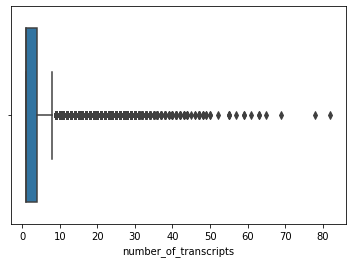

In [14]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

sns.boxplot(x=df_transcripts_per_gene['number_of_transcripts'])

<AxesSubplot:xlabel='number_of_transcripts'>

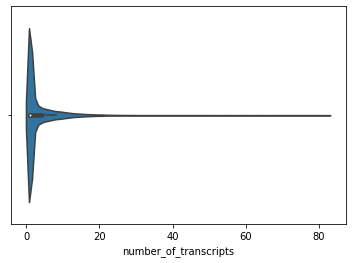

In [15]:
sns.violinplot(x=df_transcripts_per_gene['number_of_transcripts'])

## Save File

In [16]:
# Save file
file='GFF3.csv'
df_total.to_csv(file, sep=';', na_rep='n.a.')

In [17]:
df_total.head(3)

,gene,Length
ENST00000456328,ENSG00000223972,1657
ENST00000515242,ENSG00000223972,1653
ENST00000518655,ENSG00000223972,1483
